In [1]:
import numpy as np
# import pandas as pd
import librosa
# import tensorflow as tf
# from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import os
import torch
import torchaudio
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
data_file= "../data/raw/50_speakers_audio_data"

In [3]:
no_speakers_file=50

def speakers_list(no_speakers_file ,data_file ):
    speaker_l = []

    # Get all subfolders in the data_file directory
    subfolders = [f.name for f in os.scandir(data_file) if f.is_dir()]

    # Check if the requested number of speakers is available
    if no_speakers_file > len(subfolders):
        raise ValueError(f"Requested {no_speakers_file} speakers, but only {len(subfolders)} available.")

    # Select the first 'no_speakers_file' subfolders
    speaker_l = subfolders[:no_speakers_file]

    return speaker_l

speaker_list = speakers_list(no_speakers_file,data_file )

In [11]:
import os
import librosa
import soundfile as sf
import numpy as np

def create_audio_chunks(input_dir, output_dir, chunk_duration=5):
    """
    Processes audio files in speaker directories, creates 5-second chunks,
    and saves them under a structured output directory.

    Args:
        input_dir (str): Path to the input directory containing speaker folders.
        output_dir (str): Path to the output directory for saving chunks.
        chunk_duration (int): Duration of each chunk in seconds (default is 5).
    """
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Loop through each speaker's directory
    for speaker_dir in os.listdir(input_dir):
        speaker_path = os.path.join(input_dir, speaker_dir)

        # Skip if not a directory
        if not os.path.isdir(speaker_path):
            continue

        # Create corresponding speaker directory in output
        processed_speaker_dir = os.path.join(output_dir, speaker_dir)
        os.makedirs(processed_speaker_dir, exist_ok=True)

        # Process each WAV file in the speaker's directory
        for file_id, file_name in enumerate(os.listdir(speaker_path)):
            if file_name.endswith(".wav"):
                file_path = os.path.join(speaker_path, file_name)
                
                # Load the audio file
                y, sr = librosa.load(file_path, sr=None)  # Native sampling rate

                # Calculate the number of samples per chunk
                chunk_samples = chunk_duration * sr
                total_samples = len(y)

                # Split into chunks
                for chunk_id, start_sample in enumerate(range(0, total_samples, chunk_samples)):
                    # Extract the current chunk
                    chunk = y[start_sample:start_sample + chunk_samples]

                    # Skip chunks smaller than the required duration
                    if len(chunk) < chunk_samples:
                        continue

                    # Define the output file path
                    chunk_file_name = f"{speaker_dir}_file{file_id}_chunk{chunk_id}.wav"
                    chunk_file_path = os.path.join(processed_speaker_dir, chunk_file_name)

                    # Save the chunk using soundfile
                    sf.write(chunk_file_path, chunk, sr)

    print(f"Chunks created and saved under '{output_dir}'")

# Example usage
input_directory = "/Users/diwanshuyadav/Documents/prml_proj/prml_speaker_recog_spring_2025/data/raw/50_speakers_audio_data"
output_directory = "/Users/diwanshuyadav/Documents/prml_proj/prml_speaker_recog_spring_2025/data/processed/50_speakers_audio_data"
create_audio_chunks(input_directory, output_directory, chunk_duration=5)

[src/libmpg123/layer3.c:INT123_do_layer3():1776] error: part2_3_length (1600) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1776] error: part2_3_length (1952) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1776] error: part2_3_length (1984) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1776] error: part2_3_length (2720) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1776] error: part2_3_length (1696) too large for available bit count (1560)
[src/libmpg123/layer3.c:INT123_do_layer3():1776] error: part2_3_length (1984) too large for available bit count (1560)
[src/libmpg123/layer3.c:INT123_do_layer3():1776] error: part2_3_length (1600) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1776] error: part2_3_length (1824) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1776]

Chunks created and saved under '/Users/diwanshuyadav/Documents/prml_proj/prml_speaker_recog_spring_2025/data/processed/50_speakers_audio_data'


In [4]:
speaker_list

['Speaker0037',
 'Speaker0030',
 'Speaker0039',
 'Speaker0038',
 'Speaker0031',
 'Speaker0036',
 'Speaker_0006',
 'Speaker_0001',
 'Speaker_0008',
 'Speaker_0009',
 'Speaker_0000',
 'Speaker_0007',
 'Speaker_0025',
 'Speaker_0014',
 'Speaker_0013',
 'Speaker_0012',
 'Speaker_0015',
 'Speaker_0023',
 'Speaker_0024',
 'Speaker0049',
 'Speaker0047',
 'Speaker0040',
 'Speaker0041',
 'Speaker0046',
 'Speaker0048',
 'Speaker0033',
 'Speaker0034',
 'Speaker0035',
 'Speaker0032',
 'Speaker0050',
 'Speaker_0002',
 'Speaker_0005',
 'Speaker_0004',
 'Speaker_0003',
 'Speaker_0021',
 'Speaker_0019',
 'Speaker_0010',
 'Speaker_0017',
 'Speaker_0016',
 'Speaker_0011',
 'Speaker_0018',
 'Speaker_0020',
 'Speaker0043',
 'Speaker0044',
 'Speaker0028',
 'Speaker0026',
 'Speaker0045',
 'Speaker0042',
 'Speaker0027',
 'Speaker0029']

In [5]:
import librosa.display

# Function to plot the waveform, spectrogram, and MFCCs
def plot_audio_features(audio_path):
    # Load audio file
    y, sr = librosa.load(audio_path, sr=None)

    # Extract speaker name from the file path
    speaker_name = os.path.basename(audio_path).split('_')[0]

    # Plot the waveform
    plt.figure(figsize=(15, 10))
    plt.subplot(3, 1, 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title(f'Waveform - {speaker_name}')

    # Plot the spectrogram
    plt.subplot(3, 1, 2)
    D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'Spectrogram - {speaker_name}')

    # Plot the MFCCs
    plt.subplot(3, 1, 3)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    librosa.display.specshow(mfccs, x_axis='time')
    plt.colorbar()
    plt.title(f'MFCCs - {speaker_name}')

    plt.tight_layout()
    plt.show()

# Paths to the combined audio files
audio_paths = "/Users/diwanshuyadav/Documents/prml_proj/prml_speaker_recog_spring_2025/data/raw/50_speakers_audio_data/Speaker_0000"


/var/folders/6r/p_k8p2cx1513x35tz7jbhfn80000gn/T/ipykernel_86026/3552814268.py:19: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)


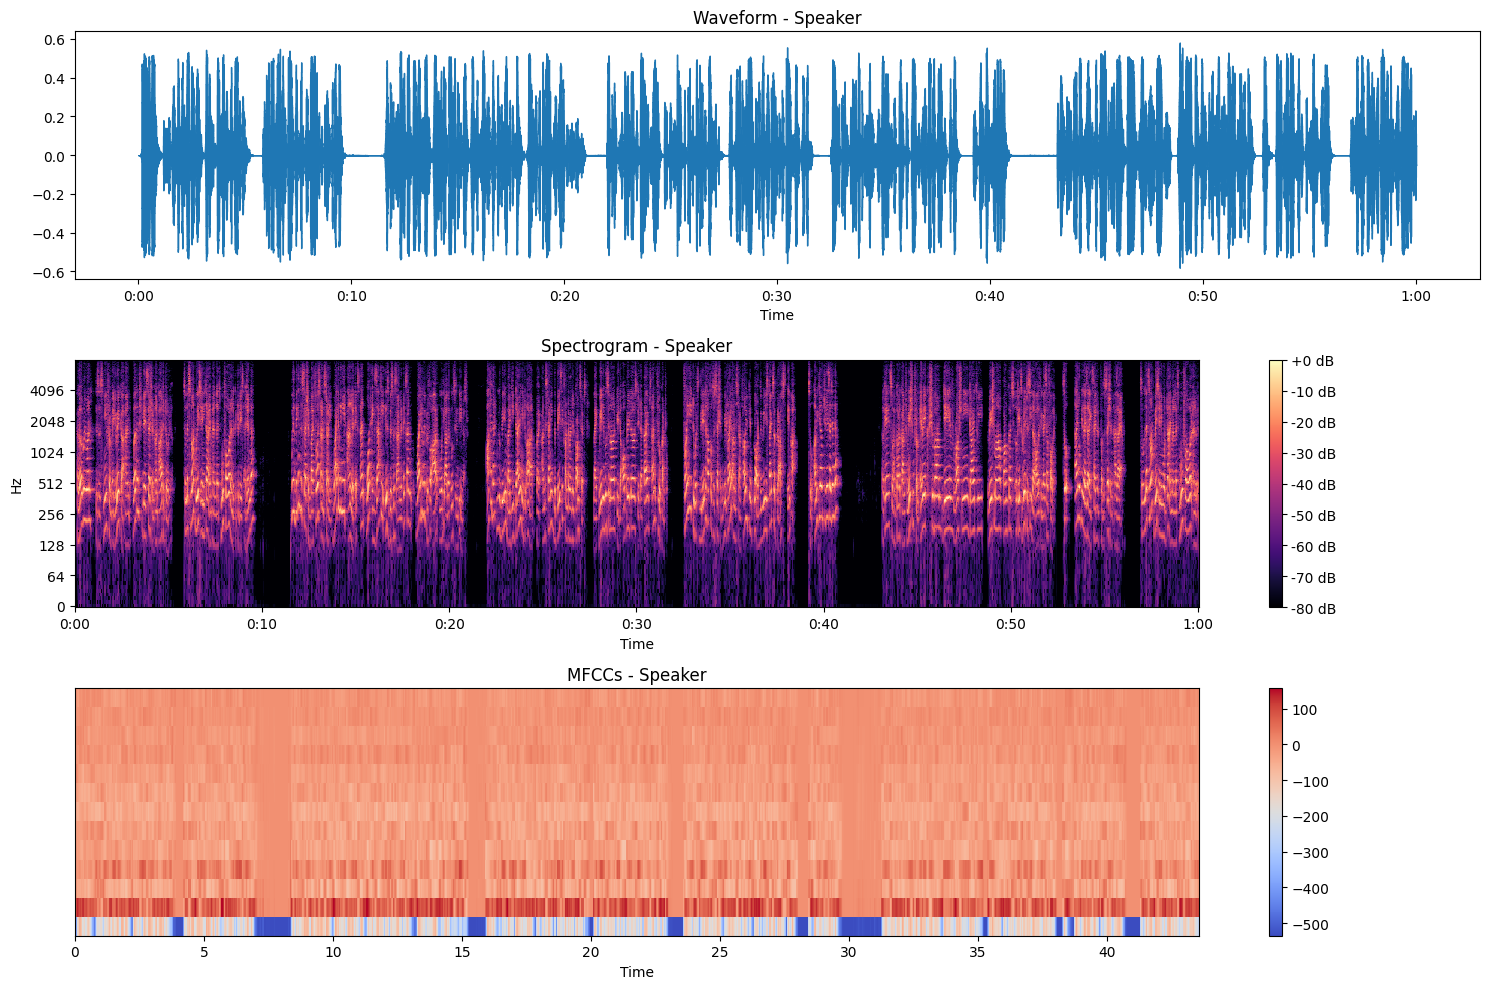

In [7]:
plot_audio_features("/Users/diwanshuyadav/Documents/prml_proj/prml_speaker_recog_spring_2025/data/raw/50_speakers_audio_data/Speaker_0000/Speaker_0000_00000.wav")

/var/folders/6r/p_k8p2cx1513x35tz7jbhfn80000gn/T/ipykernel_86026/3552814268.py:19: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(np.abs(S)) instead.
  D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)


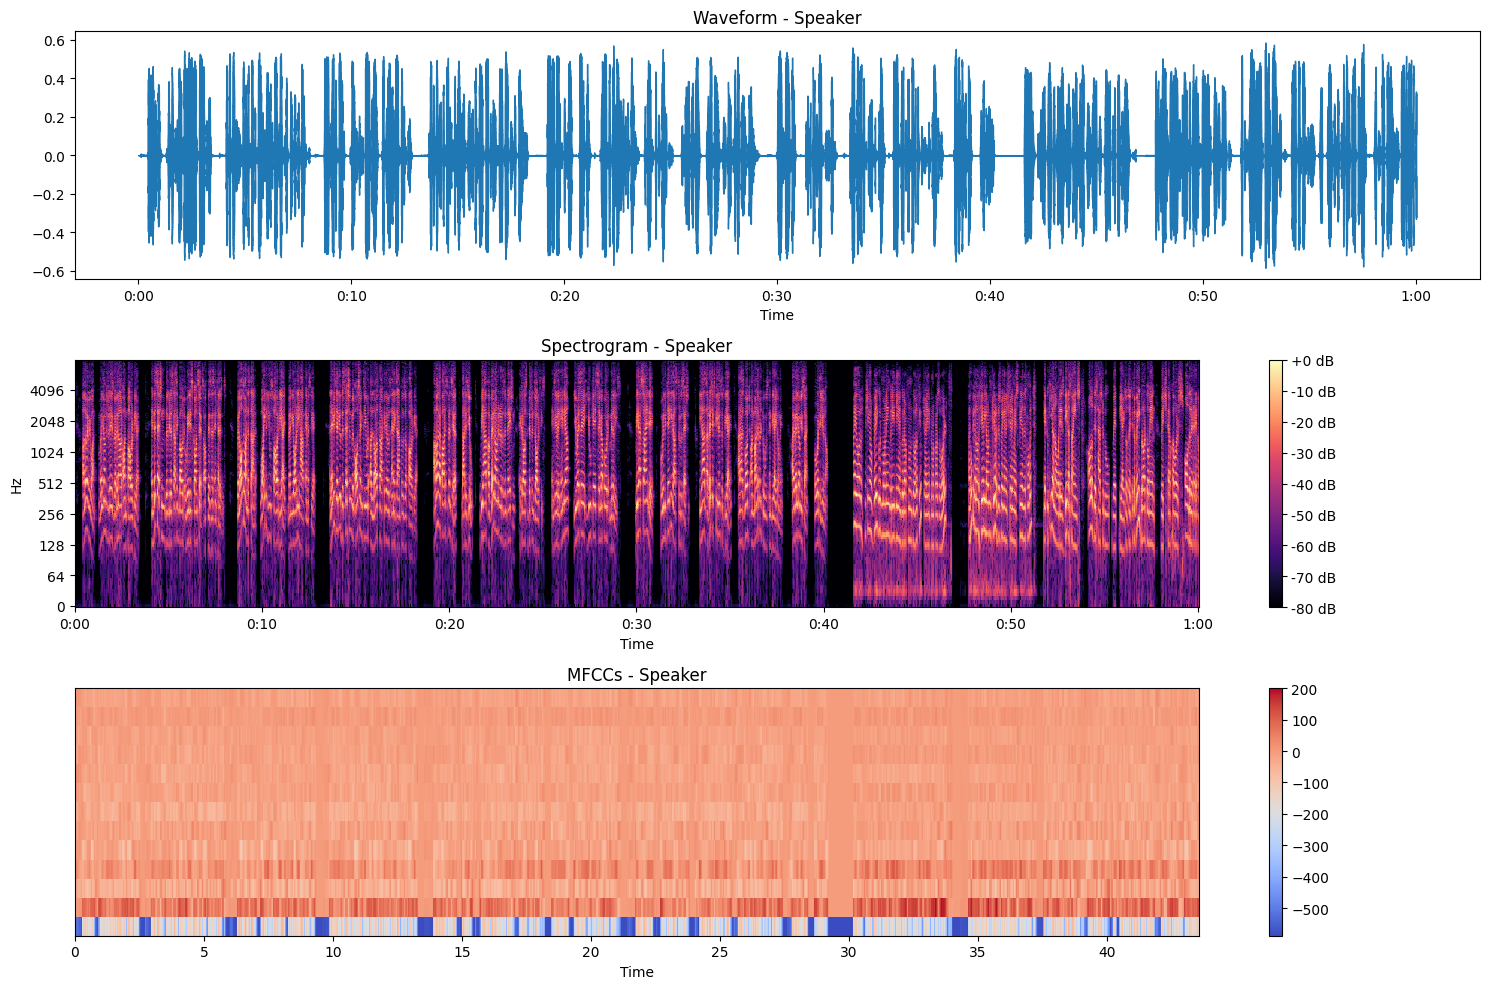

In [8]:
plot_audio_features("/Users/diwanshuyadav/Documents/prml_proj/prml_speaker_recog_spring_2025/data/raw/50_speakers_audio_data/Speaker_0001/Speaker_0001_00000.wav")

In [193]:
# def extract_mfcc(parent_dir, sub_folders, n_mfcc=13, max_pad_len=16000, mfcc_window_len=32):
#     x = []
#     y = []

#     for label, folder in enumerate(sub_folders):
#         folder_path = os.path.join(parent_dir, folder)

#         # Loop through each audio file in the folder
#         for file_name in os.listdir(folder_path):
#             if file_name.endswith('.wav'):
#                 file_path = os.path.join(folder_path, file_name)

#                 # Load audio using torchaudio. waveform shape: (channels, samples)
#                 waveform, sr = torchaudio.load(file_path)

#                 # If stereo, take the mean of channels thus converting to mono
#                 if waveform.shape[0] > 1:
#                     waveform = waveform.mean(dim=0, keepdim=True)

#                 # Define the MFCC transform. This automatically handles preemphasis, mel filtering, etc.
#                 mfcc_transform = torchaudio.transforms.MFCC(sample_rate=sr, n_mfcc=n_mfcc)
#                 # The resulting tensor has shape: (channel, n_mfcc, time)
#                 mfcc = mfcc_transform(waveform)
#                 # Squeeze out the channel dimension and transpose so that shape becomes (time, n_mfcc)
#                 mfcc = mfcc.squeeze(0).transpose(0, 1)

#                 # Scale the MFCC features (mimicking StandardScaler per file)
#                 mean = mfcc.mean(dim=0, keepdim=True)
#                 std = mfcc.std(dim=0, keepdim=True)
#                 eps = 1e-8
#                 mfcc = (mfcc - mean) / (std + eps)

#                 # Padding or truncating the MFCC along the time axis (first dimension)
#                 if mfcc.shape[0] < max_pad_len:
#                     pad_amount = max_pad_len - mfcc.shape[0]
#                     # For a 2D tensor with shape (H, W), F.pad expects (left, right, top, bottom)
#                     mfcc = F.pad(mfcc, (0, 0, 0, pad_amount))
#                 else:
#                     mfcc = mfcc[:max_pad_len, :]

#                 # Slice the MFCC into windows of mfcc_window_len
#                 num_windows = mfcc.shape[0] // mfcc_window_len
#                 for i in range(num_windows):
#                     start = i * mfcc_window_len
#                     end = start + mfcc_window_len
#                     mfcc_window = mfcc[start:end, :]
#                     x.append(mfcc_window)
#                     y.append(label)

#     # Convert list of tensors into a single tensor.
#     x = torch.stack(x)
#     y = torch.tensor(y)
#     return x, y

In [194]:
def extract_mfcc(parent_dir, sub_folders, n_mfcc=13, max_pad_len=1600 , mfcc_window_len= 32):
    x = []
    y = []
    
    for label, folder in enumerate(sub_folders):
        folder_path = os.path.join(parent_dir, folder)
        
        # Loop through each audio file in the speaker's folder
        for file_name in os.listdir(folder_path):
            if file_name.endswith('.wav'):  # Only process .wav files
                file_path = os.path.join(folder_path, file_name)
                
                audio, sr = librosa.load(file_path, sr=None)

                # Extract MFCC features
                mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
                
                scaler = StandardScaler()
                mfcc = scaler.fit_transform(mfcc.T)
#                 mfcc.T

                # Padding or truncating the MFCC feature array
                if mfcc.shape[0] < max_pad_len:
                    pad_width = max_pad_len - mfcc.shape[0]
                    mfcc = np.pad(mfcc, pad_width=((0, pad_width), (0, 0)), mode='constant')
                else:
                    mfcc = mfcc[:max_pad_len ,:]

                # Slice the MFCC into windows of window_len
                num_windows = mfcc.shape[0] // mfcc_window_len
                for i in range(num_windows):
                    start = i * mfcc_window_len
                    end = start + mfcc_window_len
                    mfcc_window = mfcc[start:end,: ]
                    x.append(mfcc_window)
                    y.append(label)
    
    x= np.array(x)
    y= np.array(y)
    return x,y


In [195]:
x,y= extract_mfcc(data_file,speaker_list)

[src/libmpg123/layer3.c:INT123_do_layer3():1776] error: part2_3_length (1600) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1776] error: part2_3_length (1952) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1776] error: part2_3_length (1984) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1776] error: part2_3_length (2720) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1776] error: part2_3_length (1696) too large for available bit count (1560)
[src/libmpg123/layer3.c:INT123_do_layer3():1776] error: part2_3_length (1984) too large for available bit count (1560)
[src/libmpg123/layer3.c:INT123_do_layer3():1776] error: part2_3_length (1600) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1776] error: part2_3_length (1824) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1776]

In [196]:
x.shape, y.shape

((125550, 32, 13), (125550,))

In [197]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
print("Training Data Shape:", x_train.shape)
print("Test Data Shape:", x_test.shape)

Training Data Shape: (100440, 32, 13)
Test Data Shape: (25110, 32, 13)


In [198]:
x_train.shape, y_train.shape

((100440, 32, 13), (100440,))

In [199]:
input_shape=(32,13)

In [200]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SpeakerCNN(nn.Module):
    def __init__(self, input_shape, no_speakers):
        super(SpeakerCNN, self).__init__()
        
        # Unpack input shape dimensions
        self.time_frames, self.mfcc_features = input_shape  # Example: input_shape=(32, 13)

        # First convolution block
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # Input: (1, time_frames, mfcc_features)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2)  # Reduces dimensions by a factor of 2

        # Second convolution block
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2)  # Further reduces dimensions by a factor of 2

        # Third convolution block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2)  # Further reduces dimensions by a factor of 2

        # Compute the flattened dimension after the convolutional layers
        conv_out_time = self.time_frames // (2 ** 3)  # Divided by pooling layers (3 times)
        conv_out_features = self.mfcc_features // (2 ** 3)  # Divided by pooling layers (3 times)
        flattened_dim = 128 * conv_out_time * conv_out_features  # 128 filters in final conv layer

        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)

        # Fully connected layers
        self.fc1 = nn.Linear(flattened_dim, 256)
        self.fc2 = nn.Linear(256, no_speakers)

    def forward(self, x):
        # Add channel dimension for CNN input: (batch_size, time_frames, mfcc_features) -> (batch_size, 1, time_frames, mfcc_features)
        x = x.unsqueeze(1)
        
        # Pass through convolutional layers
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)

        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool3(x)

        # Flatten the output for the fully connected layers
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        
        # Pass through fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # Raw logits for classification
        return x



In [201]:
model =SpeakerCNN(input_shape, no_speakers_file)

In [202]:
print(model)

SpeakerCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=50, bias=True)
)


In [204]:
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

In [205]:
output = model(x_train_tensor)
print("Output Shape:", output.shape)
print("Output:", output)

Output Shape: torch.Size([100440, 50])
Output: tensor([[-0.1668, -0.0749, -0.7279,  ...,  0.2351,  0.2457,  0.1110],
        [-0.1343, -0.4869, -0.0281,  ...,  0.0458, -0.4089, -0.1491],
        [-0.3733, -0.1040, -0.9190,  ...,  0.4232, -0.4171,  0.2045],
        ...,
        [ 0.2004,  0.1796, -0.1943,  ...,  0.4672, -0.2141,  0.9435],
        [ 0.2374,  0.5440, -0.4162,  ...,  0.2311, -0.5472,  0.1110],
        [-0.2401,  0.3267, -0.1427,  ..., -0.0054, -0.0010,  0.1399]],
       grad_fn=<AddmmBackward0>)


In [208]:
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [209]:
batch_size = 128
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [210]:
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [211]:
# Early stopping setup
patience = 20
best_val_loss = float('inf')
epochs_no_improve = 10
num_epochs = 200

In [212]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
model.to(device)

SpeakerCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=50, bias=True)
)

In [229]:
# Training loop with early stopping
best_model_wts = model.state_dict()  # Save initial model weights
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_train_loss = running_loss / len(train_dataset)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
    epoch_val_loss = val_loss / len(test_dataset)
    epoch_val_acc = correct / len(test_dataset)
    
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {epoch_train_loss:.4f}, "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")
    
    # Early stopping check
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_model_wts = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break

Epoch 1/200: Train Loss: 2.2633, Val Loss: 1.4383, Val Acc: 0.5376
Epoch 2/200: Train Loss: 1.1592, Val Loss: 0.9130, Val Acc: 0.6942
Epoch 3/200: Train Loss: 0.9140, Val Loss: 0.7082, Val Acc: 0.7592
Epoch 4/200: Train Loss: 0.8028, Val Loss: 0.6532, Val Acc: 0.7786
Epoch 5/200: Train Loss: 0.7325, Val Loss: 0.5606, Val Acc: 0.8096
Epoch 6/200: Train Loss: 0.6808, Val Loss: 0.5999, Val Acc: 0.7980
Epoch 7/200: Train Loss: 0.6469, Val Loss: 0.5114, Val Acc: 0.8218
Epoch 8/200: Train Loss: 0.6238, Val Loss: 0.5299, Val Acc: 0.8130
Epoch 9/200: Train Loss: 0.5913, Val Loss: 0.5160, Val Acc: 0.8186
Epoch 10/200: Train Loss: 0.5742, Val Loss: 0.4541, Val Acc: 0.8433
Epoch 11/200: Train Loss: 0.5598, Val Loss: 0.4383, Val Acc: 0.8460
Epoch 12/200: Train Loss: 0.5422, Val Loss: 0.5597, Val Acc: 0.8115
Epoch 13/200: Train Loss: 0.5267, Val Loss: 0.4121, Val Acc: 0.8538
Epoch 14/200: Train Loss: 0.5200, Val Loss: 0.4373, Val Acc: 0.8427
Epoch 15/200: Train Loss: 0.5026, Val Loss: 0.4255, Val A

In [230]:
# Initialize history lists
train_losses = []
val_losses = []
val_accuracies = []

best_model_wts = model.state_dict()  # Save initial model weights
best_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_train_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_train_loss)
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
    epoch_val_loss = val_loss / len(valid_loader.dataset)
    epoch_val_acc = correct / len(valid_loader.dataset)
    
    val_losses.append(epoch_val_loss)
    val_accuracies.append(epoch_val_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {epoch_train_loss:.4f}, "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")
    
    # Early stopping check
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_model_wts = model.state_dict()
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered.")
            break




Epoch 1/200: Train Loss: 0.3064, Val Loss: 0.2982, Val Acc: 0.8971
Epoch 2/200: Train Loss: 0.3043, Val Loss: 0.2996, Val Acc: 0.8982
Epoch 3/200: Train Loss: 0.3038, Val Loss: 0.3122, Val Acc: 0.8960
Epoch 4/200: Train Loss: 0.2962, Val Loss: 0.2963, Val Acc: 0.8976
Epoch 5/200: Train Loss: 0.3006, Val Loss: 0.3139, Val Acc: 0.8964
Epoch 6/200: Train Loss: 0.3014, Val Loss: 0.3221, Val Acc: 0.8925
Epoch 7/200: Train Loss: 0.3040, Val Loss: 0.2980, Val Acc: 0.9003
Epoch 8/200: Train Loss: 0.3001, Val Loss: 0.3139, Val Acc: 0.8968
Epoch 9/200: Train Loss: 0.3057, Val Loss: 0.2966, Val Acc: 0.8998
Epoch 10/200: Train Loss: 0.2981, Val Loss: 0.3044, Val Acc: 0.8926
Epoch 11/200: Train Loss: 0.2881, Val Loss: 0.3237, Val Acc: 0.8935
Epoch 12/200: Train Loss: 0.3021, Val Loss: 0.3055, Val Acc: 0.8983
Epoch 13/200: Train Loss: 0.2952, Val Loss: 0.2974, Val Acc: 0.8976
Epoch 14/200: Train Loss: 0.2919, Val Loss: 0.3085, Val Acc: 0.8972
Epoch 15/200: Train Loss: 0.3009, Val Loss: 0.3270, Val A

In [ ]:
# Optionally, load the best model weights
model.load_state_dict(best_model_wts)

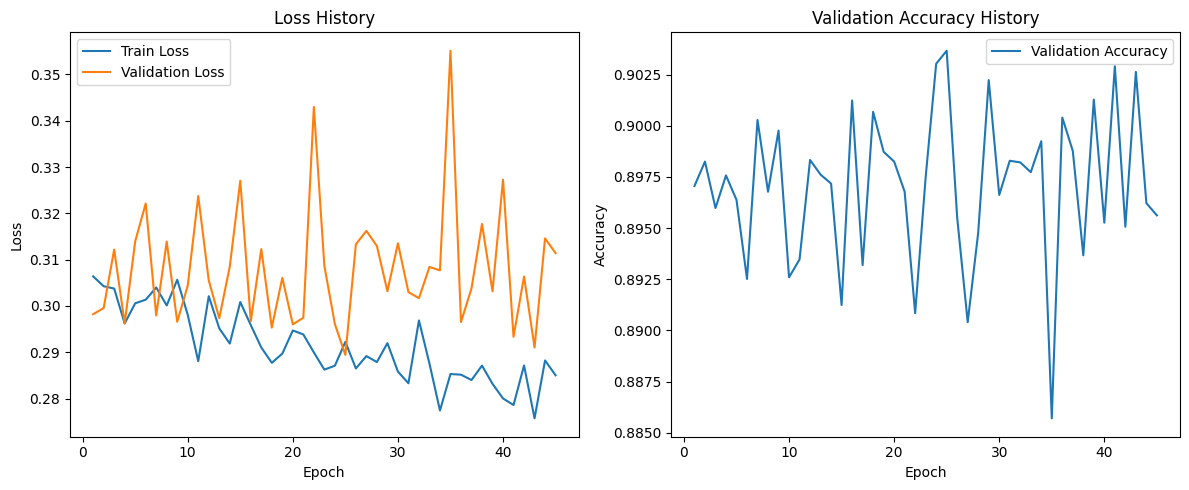

In [232]:
# Plotting accuracy and loss
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

# Plot loss history
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss History')
plt.legend()

# Plot validation accuracy history
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy History')
plt.legend()

plt.tight_layout()
plt.show()

<All keys matched successfully>

In [52]:
def plot_training_history(history):
    # Plot Accuracy
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    
    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()

K Means

In [213]:
from sklearn.cluster import KMeans

In [214]:
x_train = x_train.reshape(-1, 32 * 13)

In [215]:
x_train.shape

(100440, 416)

In [216]:
# Initialize the k-means model using 10 as there are 10 digits
kmeans = KMeans(n_clusters=50, random_state=0)
# Fit the model to the features
kmeans.fit(x_train)
# Get the cluster labels for each image
labels = kmeans.labels_

In [223]:
x_train[0]

array([-2.00223064e+00, -1.27821827e+00,  6.20716453e-01,  1.95070624e-01,
        6.99929237e-01,  5.30586600e-01,  6.19565189e-01,  1.50856733e+00,
        1.27772224e+00,  1.03727543e+00,  1.09468317e+00,  5.82951665e-01,
        1.74933577e+00, -1.78379750e+00, -8.10129642e-01,  8.12515557e-01,
        8.36921632e-02,  4.75222558e-01,  4.51950371e-01,  3.87964875e-01,
        8.32602322e-01,  4.52699721e-01,  6.06472731e-01,  5.66912532e-01,
       -1.81848809e-01,  7.04500794e-01, -1.20101011e+00, -2.27119163e-01,
        2.83197075e-01,  6.01390362e-01,  4.49648589e-01,  1.48828462e-01,
        7.43473411e-01,  3.25135559e-01,  1.04833618e-01,  8.52504194e-01,
        4.70702559e-01, -1.22658804e-01, -4.33400035e-01, -1.31235278e+00,
       -3.31390083e-01,  3.89345199e-01,  4.59509254e-01,  5.37729204e-01,
        3.22008014e-01,  6.75817370e-01,  3.92571896e-01,  1.58252448e-01,
        8.76306474e-01,  5.50083518e-01, -7.63117941e-03, -2.18954906e-01,
       -1.83752155e+00, -

In [224]:
y_train[0]

np.int64(27)

In [236]:
x_test_grp=x_test[y_test==1]
x_test_grp.shape

(348, 416)

In [237]:
x_test= x_test.reshape(-1, 32 * 13)

In [238]:
pred =kmeans.predict(x_test_grp)

In [239]:
pred.shape

(348,)

In [240]:
pred

array([23, 15, 39, 43, 16, 41, 23, 25, 29,  3, 45, 15, 25, 33, 31, 34, 39,
       29, 21, 39, 48, 45, 15, 31, 45, 39, 11,  2, 46,  5,  5, 13, 25, 24,
       40,  2, 43, 10, 10, 20, 39, 40, 19, 14, 19, 15,  1, 40, 10, 19, 39,
       30, 40, 23,  2, 47, 14, 15, 40, 23, 15, 10, 15,  1, 48, 23, 45, 23,
        4, 48,  9, 40,  2, 10, 27, 19, 29, 19, 13, 18, 47, 15, 40, 39,  2,
       49, 12, 47, 35, 38, 17,  1, 47, 22,  1, 21,  8, 21, 38, 10, 39, 20,
       37, 39, 21,  8, 39, 46, 27, 33,  4, 40, 30, 41,  9, 33, 11, 27,  7,
       23, 38, 13,  9, 47, 21, 49, 22, 37, 23, 48, 41, 17,  9, 21, 41,  1,
       23,  4, 45, 45,  5, 19, 12,  2, 28, 29, 45, 17, 10, 39, 25,  2, 22,
        2, 41, 39, 45, 41, 10, 37, 40, 16, 41, 42,  4, 34, 17, 23, 22, 41,
       10, 30, 18, 10, 28, 15,  5, 23, 40, 24, 15,  4, 23, 10, 39, 23,  5,
       37, 37, 47, 49,  2,  6, 14,  2, 39,  5,  5, 21, 22,  4, 21, 45, 47,
       15, 12, 30, 30, 45, 10, 15, 10,  1, 39, 37, 47, 21, 19, 15, 43,  2,
       37, 24, 39, 45, 37

In [221]:
sum(pred == y_test)/len(y_test)

np.float64(0.019673436877737954)

ValueError: x and y must have same first dimension, but have shapes (19,) and (10,)

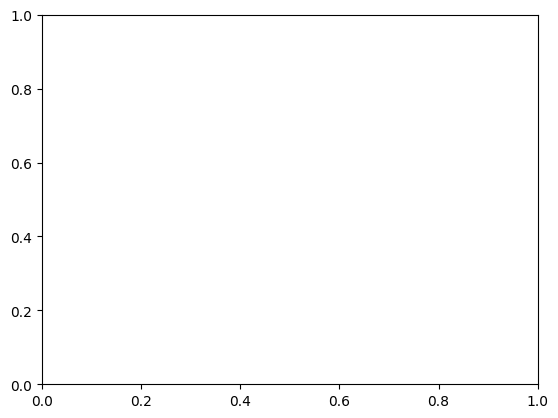

In [172]:
inertia = []
for k in range(10, 100 + 1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(x_train)
    inertia.append(kmeans.inertia_)


# Plot elbow curve
plt.plot(range(10, 100 + 1, 10), inertia, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

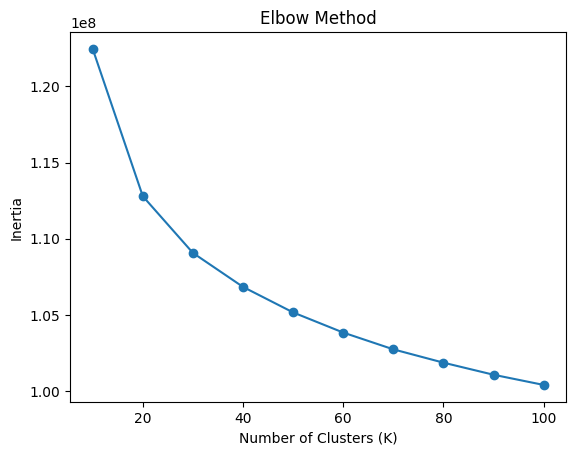

In [173]:
# Plot elbow curve
plt.plot(range(10, 100 + 1, 10), inertia, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [ ]:
import librosa

# Load the audio file
audio_path = "path_to_your_audio_file.wav"
y, sr = librosa.load(audio_path, sr=None)  # y is the audio signal, sr is the sampling rate

In [243]:
import numpy as np

# Extract features
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)  # 13 MFCC coefficients
chroma = librosa.feature.chroma_stft(y=y, sr=sr)
spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
zero_crossings = np.sum(librosa.zero_crossings(y))

# Combine features into a single vector
features = np.hstack([
    np.mean(mfccs, axis=1), 
    np.mean(chroma, axis=1), 
    np.mean(spectral_centroid, axis=1), 
    np.mean(spectral_bandwidth, axis=1),
    zero_crossings
])

In [244]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features.reshape(1, -1))  # Reshape for single sample

In [249]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=50, random_state=42)  # Define the number of clusters
kmeans.fit(scaled_features)

# Get the cluster label
cluster_label = kmeans.predict(scaled_features)
print(f"Cluster Label: {cluster_label}")

Cluster Label: [41 42 49 32 12 37 12 20 26 20 12 14 23 12 10 14 10 38 31 10 36  9 43 29
 45  4 13 14 25  0  8 39  6 20  0 22 36 13  9 26 20  4  5 47  9 33 20 26
 26 24 28 34 21 11  6 21  1  2 20 17 18 33  8 35 40 21 19 36 28 15  8 32
 16 10  7  0 36 10  3  7  3 10 10 44  7  7 30 48 27  3  7 46 18]


In [251]:
import os

all_features = []
for s in speaker_list:
    for file in os.listdir(f"/Users/diwanshuyadav/Documents/prml_proj/prml_speaker_recog_spring_2025/data/raw/50_speakers_audio_data/{s}"):
        if file.endswith(".wav"):
            y, sr = librosa.load(os.path.join(f"/Users/diwanshuyadav/Documents/prml_proj/prml_speaker_recog_spring_2025/data/raw/50_speakers_audio_data/{s}", file), sr=None)
            # Extract features
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
            chroma = librosa.feature.chroma_stft(y=y, sr=sr)
            spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
            spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
            zero_crossings = np.sum(librosa.zero_crossings(y))
            features = np.hstack([
                np.mean(mfccs, axis=1), 
                np.mean(chroma, axis=1), 
                np.mean(spectral_centroid, axis=1), 
                np.mean(spectral_bandwidth, axis=1),
                zero_crossings
            ])
            all_features.append(features)

# Scale the dataset
all_features = np.array(all_features)
scaled_features = scaler.fit_transform(all_features)

# Apply K-Means
kmeans.fit(scaled_features)
labels = kmeans.labels_
print(f"Cluster Labels for all files: {labels}")

[src/libmpg123/layer3.c:INT123_do_layer3():1776] error: part2_3_length (1600) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1776] error: part2_3_length (1952) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1776] error: part2_3_length (1984) too large for available bit count (1568)
[src/libmpg123/layer3.c:INT123_do_layer3():1776] error: part2_3_length (2720) too large for available bit count (1568)
/Users/diwanshuyadav/Documents/prml_proj/prml_speaker_recog_spring_2025/.venv/lib/python3.13/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
[src/libmpg123/layer3.c:INT123_do_layer3():1776] error: part2_3_length (1696) too large for available bit count (1560)
[src/libmpg123/layer3.c:INT123_do_layer3():1776] error: part2_3_length (1984) too large for available bit count (1560)
[src/libmpg123/layer3.c:INT123_do_layer3():1776] error: part2_3_

Cluster Labels for all files: [15 15 15 ... 10 10 10]


In [ ]:
for i in range(41,91):
    # Load the test file
    test_file_path = f"/Users/diwanshuyadav/Documents/prml_proj/prml_speaker_recog_spring_2025/data/raw/50_speakers_audio_data/Speaker_0001/Speaker_0001_000{i}.wav"
    y_test, sr_test = librosa.load(test_file_path, sr=None)

    # Extract features from the test file
    mfccs_test = librosa.feature.mfcc(y=y_test, sr=sr_test, n_mfcc=13)
    chroma_test = librosa.feature.chroma_stft(y=y_test, sr=sr_test)
    spectral_centroid_test = librosa.feature.spectral_centroid(y=y_test, sr=sr_test)
    spectral_bandwidth_test = librosa.feature.spectral_bandwidth(y=y_test, sr=sr_test)
    zero_crossings_test = np.sum(librosa.zero_crossings(y_test))

    test_features = np.hstack([
        np.mean(mfccs_test, axis=1), 
        np.mean(chroma_test, axis=1), 
        np.mean(spectral_centroid_test, axis=1), 
        np.mean(spectral_bandwidth_test, axis=1),
        zero_crossings_test
    ])

    # Scale the test features using the same scaler
    scaled_test_features = scaler.transform(test_features.reshape(1, -1))  # Reshape to 2D

    # Predict the cluster label
    test_cluster_label = kmeans.predict(scaled_test_features)
    print(f"The test file belongs to Cluster: {test_cluster_label[0]}")

The test file belongs to Cluster: 1
The test file belongs to Cluster: 1
The test file belongs to Cluster: 1
The test file belongs to Cluster: 1
The test file belongs to Cluster: 1
The test file belongs to Cluster: 1
The test file belongs to Cluster: 1
The test file belongs to Cluster: 1
The test file belongs to Cluster: 1
The test file belongs to Cluster: 1
The test file belongs to Cluster: 1
The test file belongs to Cluster: 1
The test file belongs to Cluster: 1
The test file belongs to Cluster: 1
The test file belongs to Cluster: 1
The test file belongs to Cluster: 1
The test file belongs to Cluster: 1
The test file belongs to Cluster: 1
The test file belongs to Cluster: 1
The test file belongs to Cluster: 1
The test file belongs to Cluster: 1
The test file belongs to Cluster: 1
The test file belongs to Cluster: 1
The test file belongs to Cluster: 1
The test file belongs to Cluster: 1
The test file belongs to Cluster: 1
The test file belongs to Cluster: 1
The test file belongs to Clu

: 